# measurement grouping をしていないコード

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time
import datetime

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_brooklyn")
simulator = Aer.get_backend("qasm_simulator")
device = provider.backends.ibmq_brooklyn

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_27310/4025133605.py:5: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  device = provider.backends.ibmq_brooklyn


In [4]:
def adjacency_list_for_star_graph(n):
    """
    Input
        n : int, size of the star graph
    Output
        graph : list of list, adjacency list of the star graph
    """
    graph = []
    if n == 1:
        graph.append([])
    else:
        graph.append(list(range(1,n)))
        for j in range(1, n):
            graph.append([0])
    return graph

def list_to_matrix(graph):
    """
    Input
        graph : list of list (adjacency matrix)
    Output
        adj_matrix : 2d matrix (n * n)
        
    -> time complexity : O(n^2)
    """
    n = len(graph)
    adj_mat = []
    for i in range(n):
        row = [0] * n
        for j in graph[i]:
            row[j] = 1
        adj_mat.append(row)
    return adj_mat

In [5]:
def adjacency_list_for_path_graph(n):
    """
    Input
        n : int, size of the path graph
    Output
        graph : list of list, adjacency list of the path graph
    """
    graph = []
    if n == 1:
        graph.append([])
    else:
        graph.append([1])
        for j in range(1, n - 1):
            graph.append([j - 1, j + 1])
        graph.append([n - 2])
    return graph

In [6]:
vertex_list = [11, 17, 18, 19, 25,
               33, 32, 31, 39, 45,
               46, 47, 48, 49, 40,
               35, 36, 37, 26, 23,
               22, 21, 12,  8,  7,
                6,  5,  4,  3,  2,
                1,  0, 10, 13, 14,
               15, 24, 29, 28, 27,
               38, 41, 42, 43, 52,
               56, 57, 58, 59, 60,
               61, 62, 63, 64, 54,
               51, 50] # 57 qubits # simulator
max_size = len(vertex_list) # largest graph size
# vertex_list += [9,16,20,30,34,44,53,55] # add extra qubits up to 65
initial_layouts = [vertex_list[:n] for n in range(1, max_size + 1)] # initial_layouts
F_list = [3 * i + 1 for i in range(max_size // 3)] # subset of focused vertices of graph size max_size
Fs = [F_list[:(n+1) // 3] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_path_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution

In [7]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)
print("F_list:", F_list)
print("lengths of initial_layout:", [len(i) for i in initial_layouts])
pprint.pprint(initial_layouts[:10])

max_size: 57
shots_per_circuit: 8192
F_list: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
lengths of initial_layout: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[[11],
 [11, 17],
 [11, 17, 18],
 [11, 17, 18, 19],
 [11, 17, 18, 19, 25],
 [11, 17, 18, 19, 25, 33],
 [11, 17, 18, 19, 25, 33, 32],
 [11, 17, 18, 19, 25, 33, 32, 31],
 [11, 17, 18, 19, 25, 33, 32, 31, 39],
 [11, 17, 18, 19, 25, 33, 32, 31, 39, 45]]


In [8]:
def path_graph_state(size, barrier=False):
    if size <= 1:
        qc = QuantumCircuit(size)
        return qc
    graph_state = QuantumCircuit(size)
    graph_state.h(range(size))
    if barrier:
        graph_state.barrier()
    for i in [i for i in range(size) if i % 2 == 0][:-1]:
        graph_state.cz(i, i + 1)
    if size % 2 == 0:
        graph_state.cz(size - 2, size - 1)
    for i in [i for i in range(size) if i % 2 == 1][:-1]:
        graph_state.cz(i, i + 1)
    if size % 2 == 1:
        graph_state.cz(size - 2, size - 1)
    return graph_state

In [9]:
qcs = [path_graph_state(size) for size in range(1, max_size+1)]
print(len(qcs), "qcs")

57 qcs


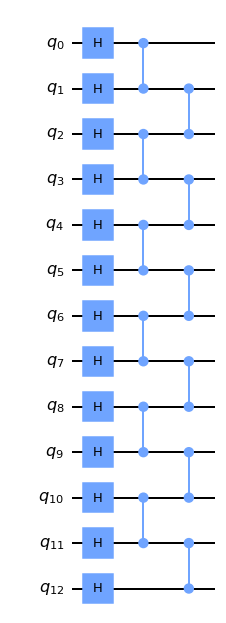

In [10]:
qcs[12].draw("mpl")

In [11]:
def prepare_path_graph_qcs(qc,
                           adj_list,
                           optimization_level=0,
                           initial_layout=None):
    """
    Return
        qcs: quantum circuits to be implemented
        nums_divide: numbers of how many the quantum circuits are prepared for one graph
        nums_meas_cal: numbers of measurement calibration circuits
        initial_layouts_: 
    """
    n = qc.num_qubits
    qcs, nums_meas_cal, initial_layouts_ = [], [], []
    
    if n <= 1:
        return [], [], [], []

    # first term: XZXZ...ZXZXZ <- measurement grouping
    new_qc1 = qc.copy("XZ pattern")
    new_qc1 += QuantumCircuit(n, n)
    new_qc1.h(range(n)[::2])
    new_qc1.barrier()
    new_qc1.measure(range(n), range(n)[::-1]) # measure all
    new_qc1 = transpile(new_qc1, backend=backend, basis_gates=['sx','rz','cx'], 
                        optimization_level=optimization_level, 
                        initial_layout=initial_layout, seed_transpiler=42)

    # second term: ZXZX...XZXZX <- measurement grouping
    new_qc2 = qc.copy("ZX pattern")
    new_qc2 += QuantumCircuit(n, n)
    new_qc2.h(range(n)[1::2])
    new_qc2.barrier()
    new_qc2.measure(range(n), range(n)[::-1]) # measure all
    new_qc2 = transpile(new_qc2, backend=backend, basis_gates=['sx','rz','cx'], 
                        optimization_level=optimization_level, 
                        initial_layout=initial_layout, seed_transpiler=42)

    # for mitigation circuits
    qr = QuantumRegister(n)
    meas_cal_circuits, _ = tensored_meas_cal(mit_pattern=[[i] for i in range(n)], qr=qr, circlabel='mcal')
    for i, meas_cal_circuit in enumerate(meas_cal_circuits):
        meas_cal_circuits[i] = transpile(meas_cal_circuit, backend=backend, basis_gates=['sx','rz','cx'], 
                                         optimization_level=optimization_level,
                                         initial_layout=initial_layout, seed_transpiler=42)
    nums_meas_cal.append(len(meas_cal_circuits))

    qcs += ([new_qc1, new_qc2] + meas_cal_circuits)
    initial_layouts_ += ( [initial_layout, initial_layout] + [initial_layout] * len(meas_cal_circuits) )

    return qcs, [1,1], nums_meas_cal, initial_layouts_

In [12]:
def prepare_path_graph_qcs_list(qc_graphs,  # list of qiskit.QuantumCircuit
                     adj_lists,             # list of adjacency list
                     optimization_level=0,  # int
                     initial_layouts=None,
                     mitigation_limit=15):
    """
    qcs_list :                   circuits to be executed on the real device
    nums_divide_list :      the information of how I divided a large shots to several circuits
    nums_meas_cal_list : the information of how I prepared the measurement_circuits for CTMP calibration
    initial_layouts_list :     used in execute_circuits function
    """
    qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = [], [], [], []
    if initial_layouts == None:
        initial_layouts = [list(range(len(adj_list))) for adj_list in adj_lists]
    for i, (qc, adj_list, initial_layout) in enumerate(zip(qc_graphs, adj_lists, initial_layouts)):
        qcs, nums_divide, nums_meas_cal, initial_layouts_ = \
            prepare_path_graph_qcs(qc, 
                                   adj_list,
                                   optimization_level=optimization_level, 
                                   initial_layout=initial_layout)
        nums_meas_cal_list.append(nums_meas_cal)
        initial_layouts_list += initial_layouts_
        qcs_list += qcs
        nums_divide_list.append(nums_divide)
    return qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list

In [13]:
qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = \
    prepare_path_graph_qcs_list(qcs, 
                                adj_lists, 
                                optimization_level=3,
                                initial_layouts=[vertex_list[:qc.num_qubits] for qc in qcs],
                                mitigation_limit=100)
print("the number of graph state circuits is: ", len(qcs_list))

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_27310/3281897158.py:20: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  new_qc1 += QuantumCircuit(n, n)
/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


the number of graph state circuits is:  224


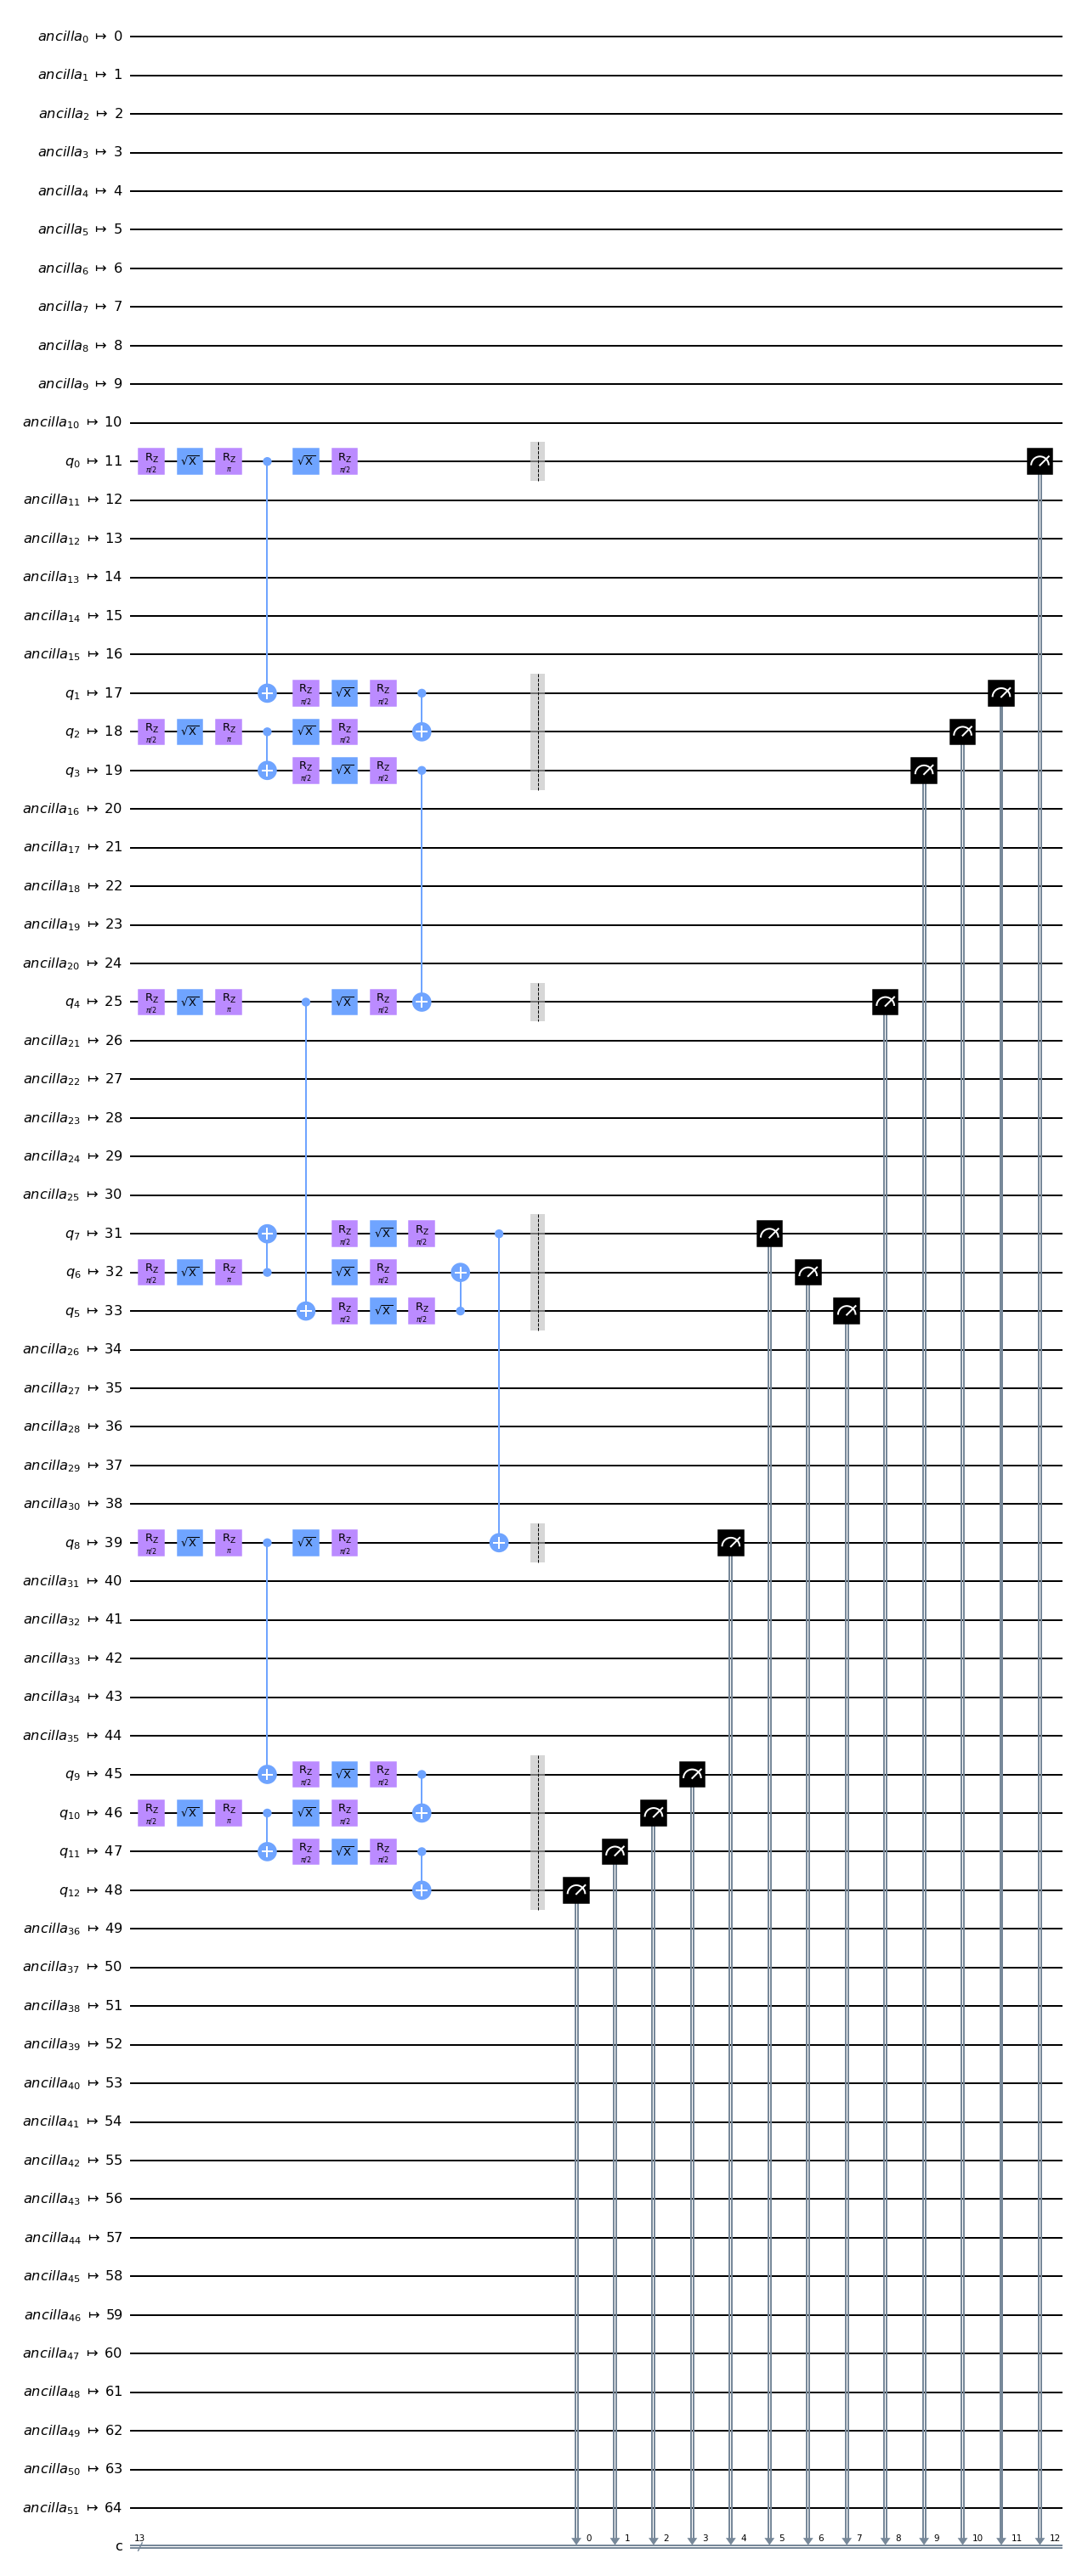

In [14]:
qcs_list[44].draw("mpl")

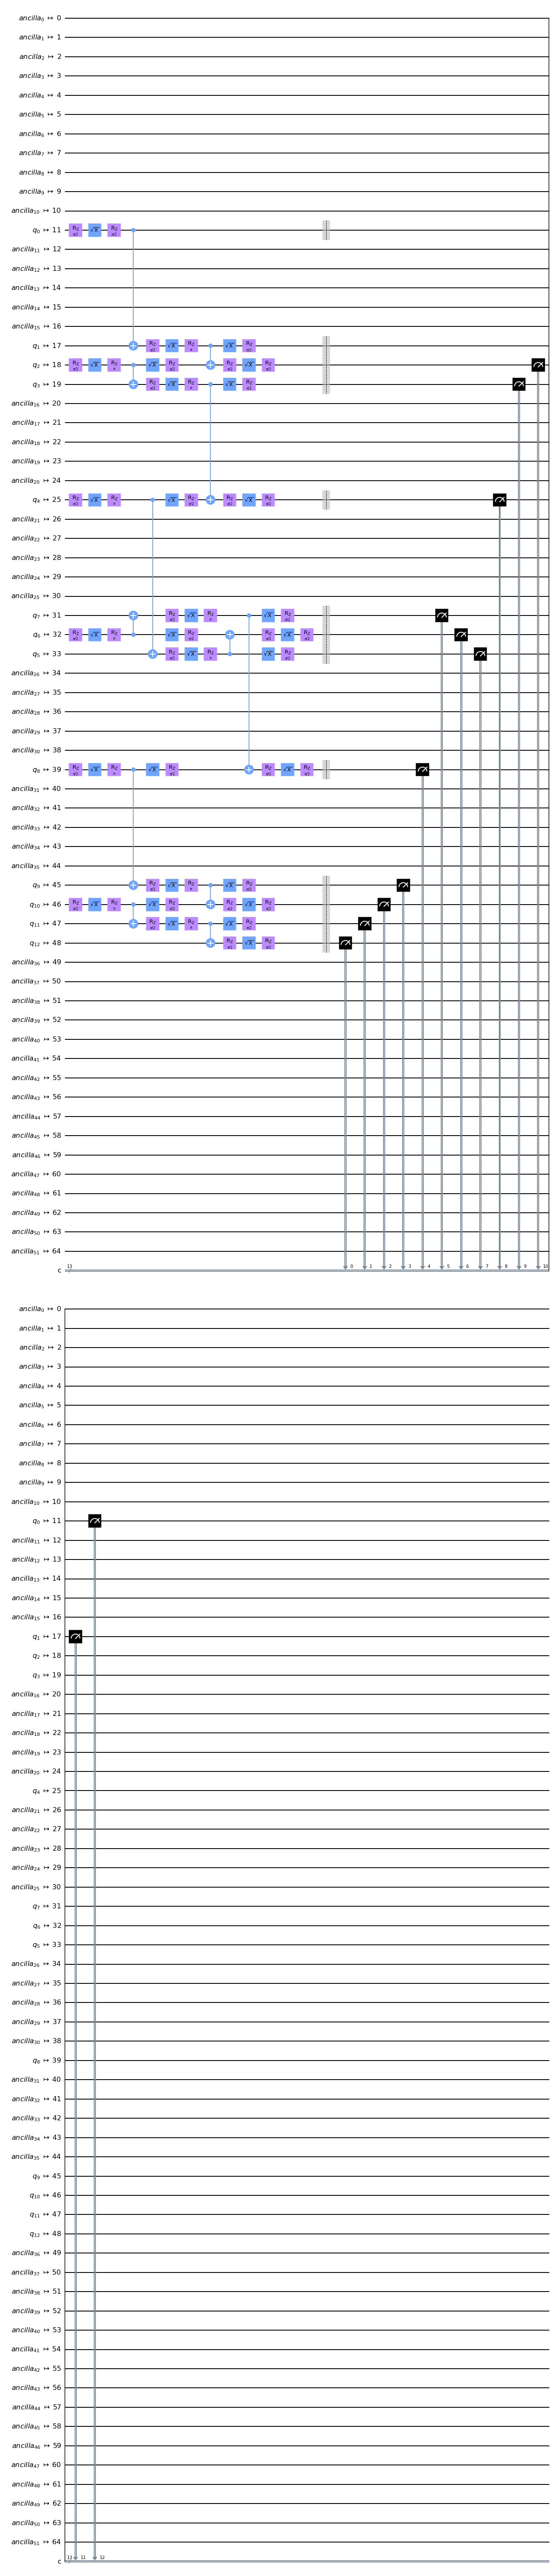

In [15]:
qcs_list[45].draw("mpl")

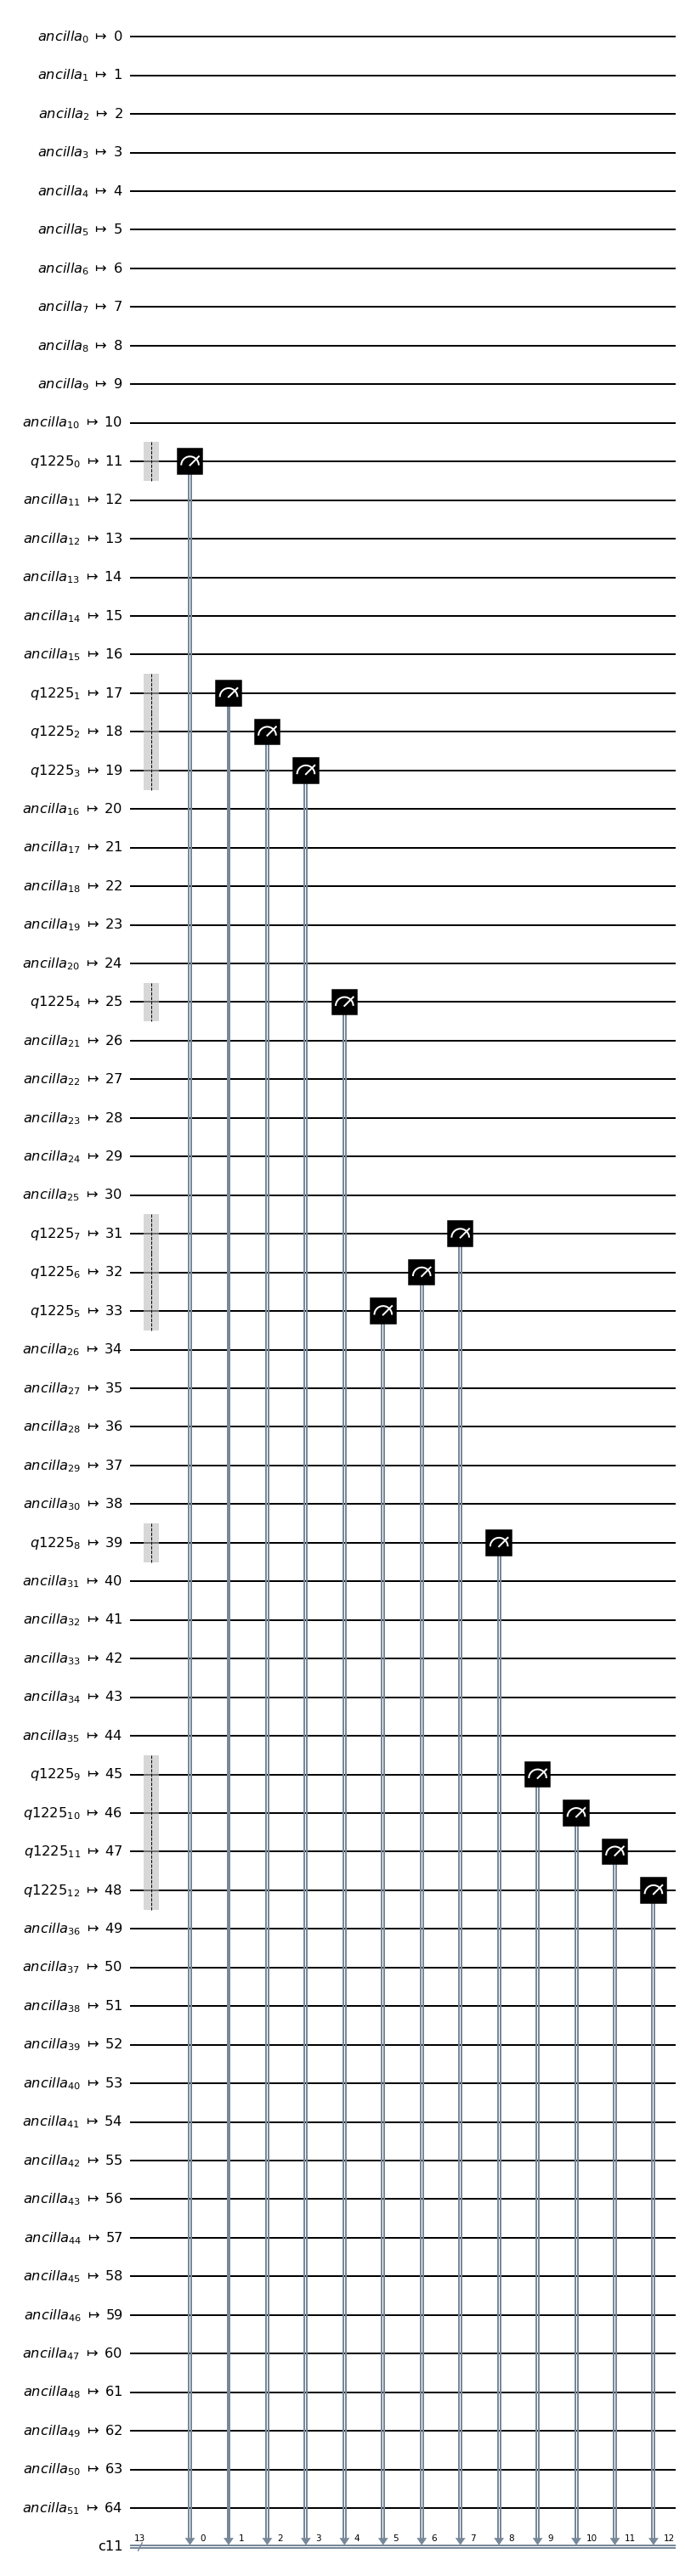

In [16]:
qcs_list[46].draw("mpl")

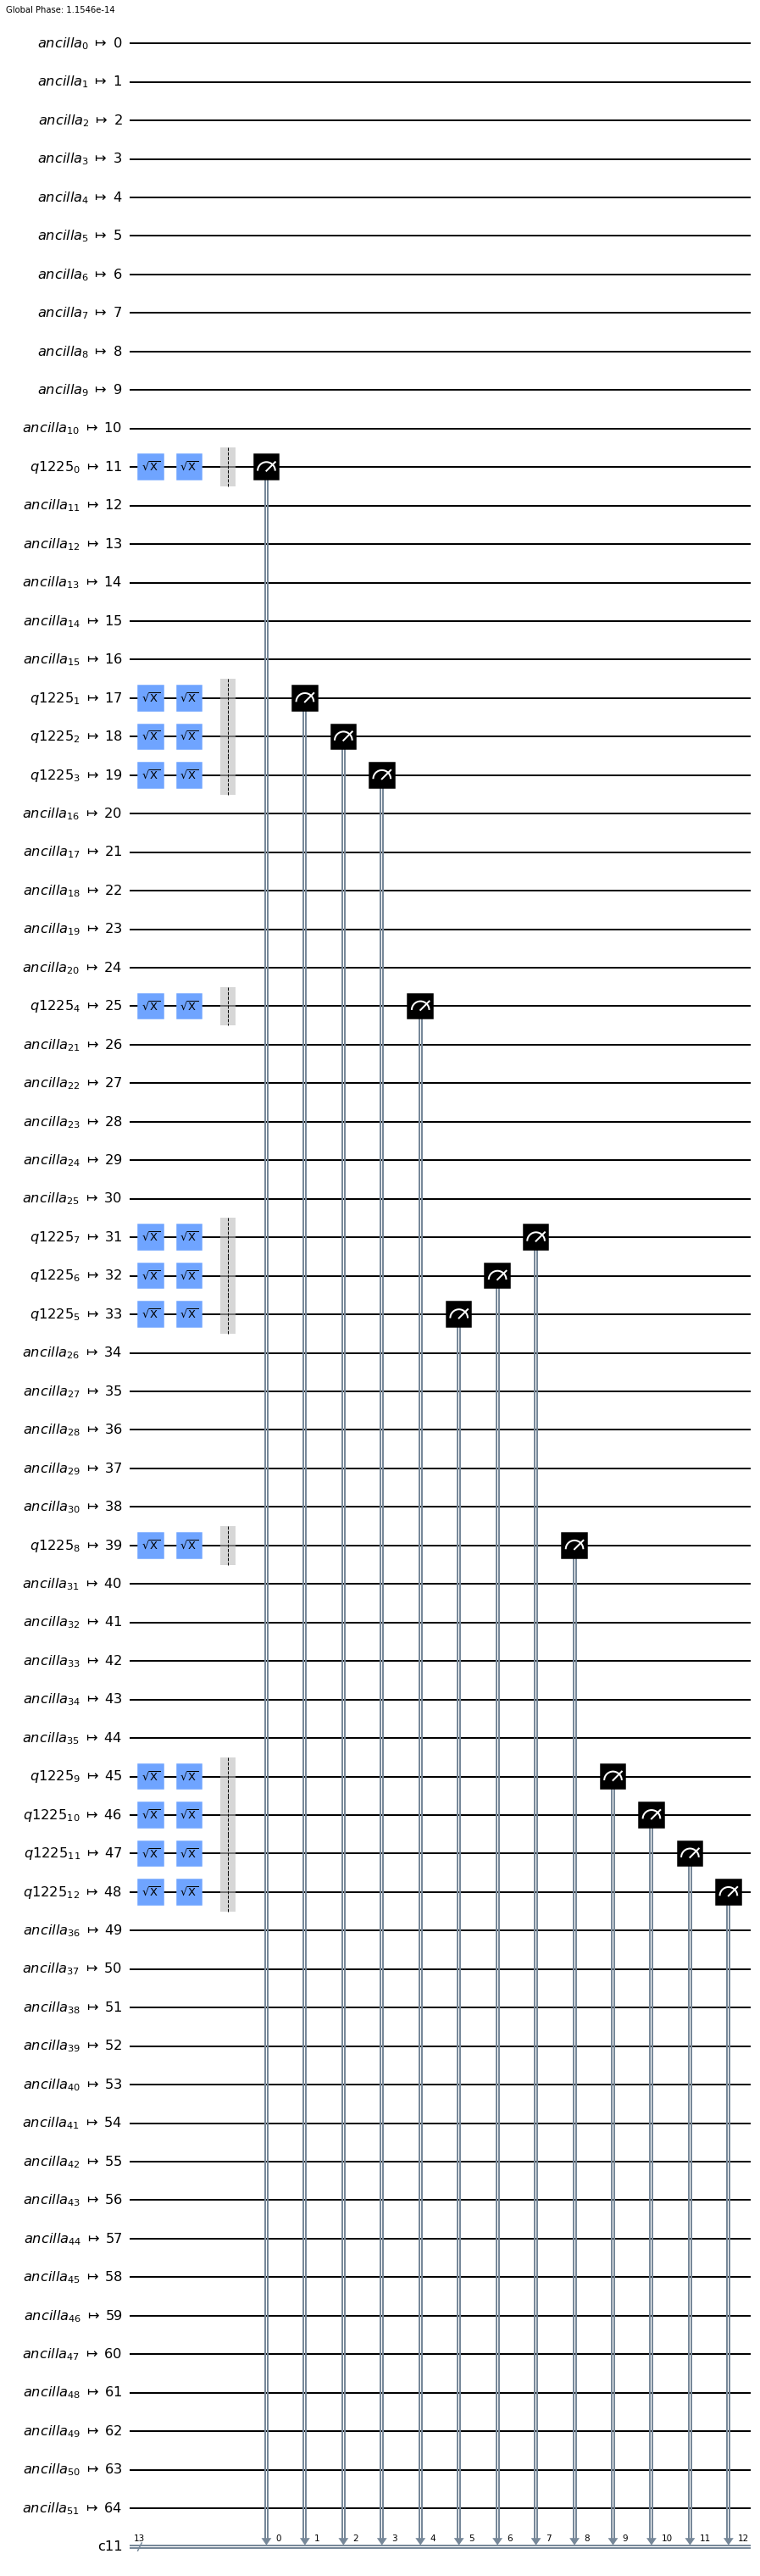

In [17]:
qcs_list[47].draw("mpl")

In [18]:
def execute_circuits(qcs, 
                     backend,
                     shots = 8192, 
                     max_experiments = 900,
                     optimization_level = 0):
    print("given provider: ", provider)
    print("running on", backend)
    jobs, i = [], 0
    while i < len(qcs):
        jobs.append(execute(qcs[i:i + max_experiments], backend=backend, shots=shots, optimization_level=optimization_level))
        print("circuits from", i, "to", min(i + max_experiments - 1, len(qcs)), "are put on the real device.")
        i += max_experiments
    return jobs

In [19]:
jobs = execute_circuits(qcs_list,
                        backend=backend,
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=0)
print(len(jobs), "jobs")
print("job_id:", jobs[0].job_id())

given provider:  <AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>
running on ibmq_brooklyn
circuits from 0 to 224 are put on the real device.
1 jobs
job_id: 6163f3a3fc7bdfa62a43ef79


## save job_id and machine property to pickle file

In [20]:
dt_now = datetime.datetime.now()
job_ids_filename = "job_ids_brooklyn_path_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [21]:
with open(job_ids_filename, "wb") as f:
    pickle.dump([job.job_id() for job in jobs], f)

In [22]:
with open("brooklyn_properties_path_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

## process the measurement results

In [23]:
def arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100):
    pos = 0
    results_graph_states = []
    results_meas_cal = []
    for i, (nums_divide, nums_meas_cal) in enumerate(zip(nums_divide_list, nums_meas_cal_list)): # graph wise
        for num_divide in nums_divide: # term wise
            results_graph_states += results_list[pos:pos + num_divide]
            pos += num_divide
        if i < limit: # start from 2
            for num_meas_cal in nums_meas_cal: # term wise
                results_meas_cal.append(merge_results(results_list[pos:pos + 2]))
                pos += num_meas_cal
    return results_graph_states, results_meas_cal

In [24]:
def job_ids_to_result(job_ids, device):
    result_list = []
    for job_id in job_ids:
        result_list.append(device.retrieve_job(job_id).result())
    return result_list

In [25]:
def flatten_results_jobs_list(results_jobs_list):
    results_list = []
    for one_job_results in results_jobs_list:
        results = separate_results(one_job_results)
        results_list += results
    return results_list

In [26]:
def separate_results(one_job_results):
    return [qiskit.result.Result(backend_name=one_job_results.backend_name, 
                                 backend_version=one_job_results.backend_version,
                                 qobj_id=one_job_results.qobj_id, 
                                 job_id=one_job_results.job_id,
                                 success=True,
                                 results=[results]) for results in one_job_results.results]

In [27]:
def merge_results(results_list):
    results = []
    for res in results_list:
        results += res.results
    return qiskit.result.Result(backend_name=results_list[0].backend_name, 
                                 backend_version=results_list[0].backend_version,
                                 qobj_id=results_list[0].qobj_id, 
                                 job_id=results_list[0].job_id,
                                 success=True,
                                 results=results)

In [ ]:
with open(job_ids_filename, "rb") as f:
     job_ids = pickle.load(f)
results_jobs_list = job_ids_to_result(job_ids, device)
print("length of results_jobs_list: ", len(results_jobs_list))
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
del results_jobs_list
results_graph_states, results_meas_cal = arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100)
print("length of results_meas_cal: ", len(results_meas_cal))
del results_list

In [ ]:
def results_list_to_counts_dict_list(results_list):
    counts_dict_list = []
    for results in results_list:
        counts_dict_list.append(results.get_counts())
    return counts_dict_list

In [ ]:
counts_dict_list = results_list_to_counts_dict_list(results_graph_states)
print("length of counts_dict_list: ", len(counts_dict_list))
del results_graph_states

In [ ]:
tensored_meas_mitigator_list = []
for n in range(2, max_size + 1):
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_fitter = TensoredMeasFitter(results_meas_cal[n - 2], mit_pattern=mit_pattern)
    tensored_meas_mitigator_list.append( meas_fitter.filter )
print("length of tensored_meas_mitigator_list: ", len(tensored_meas_mitigator_list))
del results_meas_cal

In [ ]:
def remaining_vertices(adj_list, n, F):
    remaining = set(range(n)) - set(F)
    for m in F:
        for v in adj_list[m]:
            remaining.discard(v)
    return list(remaining)

In [ ]:
def extract_two_qubit_counts(counts, pos1, pos2):
    ret_counts = {"00": 0, "01": 0, "10": 0, "11": 0}
    for k, v in counts.items():
        ret_counts[k[pos1] + k[pos2]] += v
    return ret_counts

In [ ]:
def extract_three_qubit_counts(counts, pos1, pos2, pos3):
    ret_counts = {"000": 0, "001": 0, "010": 0, "011": 0, 
                  "100": 0, "101": 0, "110": 0, "111": 0}
    for k, v in counts.items():
        ret_counts[k[pos1] + k[pos2] + k[pos3]] += v
    return ret_counts

In [ ]:
def extract_sub_counts(counts_xz, counts_zx, center, n):
    if center & 1:
        if center == n - 1:
            return extract_two_qubit_counts(counts_zx, n - 2, n - 1), [n - 2, n - 1]
        else:
            return extract_three_qubit_counts(counts_zx, center - 1, center, center + 1), [center - 1, center, center + 1]
    else:
        if center == n - 1:
            return extract_two_qubit_counts(counts_xz, n - 2, n - 1), [n - 2, n - 1]
        elif center == 0:
            return extract_two_qubit_counts(counts_xz, 0, 1), [0, 1]
        else:
            return extract_three_qubit_counts(counts_xz, center - 1, center, center + 1), [center - 1, center, center + 1]

In [ ]:
def compute_stddev_of_grouping(stddevs):
    return np.sqrt(sum([stddev ** 2 for stddev in stddevs]))

In [ ]:
def analyze_circuits_tensored(adj_lists, Fs, counts_dict_list, tensored_meas_mitigator_list=None, limit=100):
    """
    Input
        adj_lists         : list of adjacency list
        Fs                : list of vertex subset
        counts_dict_list  : list of int list (list of counts)
        tensored_meas_mitigator_list : measurement mitigator list
    Output
        expval_all_list : list of float (correlation of each graph)
        stddev_all_list : list of float (standard deviation of each graph)
        Es_all_list     : list of list (term-wise correlation of each graph)
        Ds_all_list     : list of list (term-wise stddev of each graph)
    """
    assert len(adj_lists) == len(Fs)
    corr_all_list, stddev_all_list, Es_all_list, Ds_all_list = [], [], [], []

    for adj_list, F in zip(adj_lists, Fs):
        t1 = time.time()
        n = len(adj_list)
        if n > limit:
            break
        print("graph size:", len(adj_list))
        if n <= 1:
            print("skipped\n")
            corr_all_list.append(0)
            stddev_all_list.append(0)
            Es_all_list.append([])
            Ds_all_list.append([])
            continue
        
        Es_F, Ds_F, corr_F = [], [], 0
        remaining = remaining_vertices(adj_list, n, F)
        
        # XZXZXZXZ
        tt1 = time.time()
        if tensored_meas_mitigator_list is not None:
            counts_xz = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2)] ) # n = 2 -> 0, n = 10 -> 16
        else:
            counts_xz = counts_dict_list[2 * (n - 2)]
        tt2 = time.time()
        print(tt2 - tt1, "s")
        
        # ZXZXZXZX
        tt1 = time.time()
        if tensored_meas_mitigator_list is not None:
            counts_zx = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2) + 1] ) # n = 2 -> 1, n = 10 -> 17
        else:
            counts_zx = counts_dict_list[2 * (n - 2) + 1]
        tt2 = time.time()
        print(tt2 - tt1, "s")
        
        for m in F:
            counts, poses = extract_sub_counts(counts_xz, counts_zx, m, n)
            corr_itself, stddev_itself = mit.expectation_value(counts, qubits=poses, clbits=poses, meas_mitigator=None)
            corr_deg = corr_itself * len(adj_list[m])
            Es_m, Ds_m = [corr_itself], [stddev_itself * len(adj_list[m])]
            for j, _ in enumerate(adj_list[m]):
                counts, poses = extract_sub_counts(counts_xz, counts_zx, j, n)
                expval, stddev = mit.expectation_value(counts, qubits=poses, clbits=poses, meas_mitigator=None)
                Es_m.append(expval)
                Ds_m.append(stddev)
            sum_corr = corr_deg + sum(Es_m[1:])
            print("correlation on n[", m, "]:", sum_corr)
            corr_F += sum_corr
            Es_F.append(Es_m)
            Ds_F.append(Ds_m)

        # remainig part
        Es_R, Ds_R = [], []
        for i, _ in enumerate(remaining):
            counts, poses = extract_sub_counts(counts_xz, counts_zx, i, n)
            expval, stddev = mit.expectation_value(counts, qubits=poses, clbits=poses, meas_mitigator=None)
            Es_R.append(expval)
            Ds_R.append(stddev)
        corr_R = sum(Es_R)
        print("correlation on remaining vertices:", corr_R)

        corr_F *= np.sqrt(2)
        corr_all = corr_F + corr_R
        corr_all_list.append(corr_all)
        stddev_all_list.append(np.sqrt(2 * sum([dev ** 2 for Ds_m in Ds_F for dev in Ds_m]) + sum([dev ** 2 for dev in Ds_R])) )
        Es_all_list.append([Es_F, Es_R])
        Ds_all_list.append([Ds_F, Ds_R])
        print("total correlation:", corr_all, "\n")
    return corr_all_list, stddev_all_list, Es_all_list, Ds_all_list

In [24]:
# without QREM
corr_list_real, stddev_list_real, Es_list_real, Ds_list_real = analyze_circuits_tensored(adj_lists, Fs, counts_dict_list)

graph size: 1
skipped

graph size: 2
correlation on n[ 1 ]: 1.75390625
correlation on remaining vertices: 0
total correlation: 2.4803980058809363 

graph size: 3
correlation on n[ 1 ]: 3.44970703125
correlation on remaining vertices: 0
total correlation: 4.878622469807577 

graph size: 4
correlation on n[ 1 ]: 3.3984375
correlation on remaining vertices: 0.912841796875
total correlation: 5.718958200252316 

graph size: 5
correlation on n[ 1 ]: 3.408447265625
correlation on n[ 4 ]: 1.6455078125
correlation on remaining vertices: 0
total correlation: 7.147371815108751 

graph size: 6
correlation on n[ 1 ]: 3.40673828125
correlation on n[ 4 ]: 3.164794921875
correlation on remaining vertices: 0
total correlation: 9.293551381444482 

graph size: 7
correlation on n[ 1 ]: 3.388427734375
correlation on n[ 4 ]: 3.154052734375
correlation on remaining vertices: 0.936767578125
total correlation: 10.189232188592335 

graph size: 8
correlation on n[ 1 ]: 3.378173828125
correlation on n[ 4 ]: 3.147

correlation on n[ 10 ]: 3.29736328125
correlation on n[ 13 ]: 3.33740234375
correlation on n[ 16 ]: 3.355224609375
correlation on n[ 19 ]: 3.197021484375
correlation on n[ 22 ]: 3.318115234375
correlation on n[ 25 ]: 3.28271484375
correlation on n[ 28 ]: 3.26171875
correlation on n[ 31 ]: 3.30908203125
correlation on n[ 34 ]: 2.72705078125
correlation on n[ 37 ]: 3.048095703125
correlation on n[ 40 ]: 2.71728515625
correlation on n[ 43 ]: 2.331298828125
correlation on remaining vertices: 0
total correlation: 66.73976254715745 

graph size: 46
correlation on n[ 1 ]: 3.38720703125
correlation on n[ 4 ]: 3.164306640625
correlation on n[ 7 ]: 3.446044921875
correlation on n[ 10 ]: 3.27587890625
correlation on n[ 13 ]: 3.34619140625
correlation on n[ 16 ]: 3.330322265625
correlation on n[ 19 ]: 3.16943359375
correlation on n[ 22 ]: 3.34521484375
correlation on n[ 25 ]: 3.260009765625
correlation on n[ 28 ]: 3.3037109375
correlation on n[ 31 ]: 3.292724609375
correlation on n[ 34 ]: 2.721435

In [ ]:
# with tensored QREM
tensored_size = 9
tensored_corr_list_real, tensored_stddev_list_real, tensored_Es_list_real, tensored_Ds_list_real = analyze_circuits_tensored(adj_lists, 
                                                                                                                             Fs,
                                                                                                                             counts_dict_list,
                                                                                                                             tensored_meas_mitigator_list,
                                                                                                                             limit=tensored_size)

In [22]:
c_bounds = [0] + [n + (n // 3) for n in range(2, max_size + 1)]
q_bounds = [0]
for n in range(2, max_size + 1):
    q_bounds.append( 2 * (np.sqrt(2) * 2 - 1) * (n // 3) + n - ((n + 1) // 3))
    if (n + 1) % 3 == 0:
        q_bounds[-1] += (np.sqrt(2) * 2 - 1)

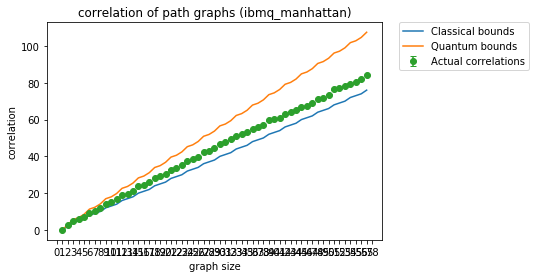

In [26]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds, label="Classical bounds") # , marker="o", markersize=1)
plt.plot(list(range(1, max_size + 1)), q_bounds, label="Quantum bounds") # , marker="x", markersize=1)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real, label="Actual correlations", fmt="o", yerr=stddev_list_real, capsize=3)
# plt.errorbar(list(range(1, 11 + 1)), tensored_corr_list_real, label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real, capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.title("correlation of path graphs (ibmq_brooklyn)")
plt.show()

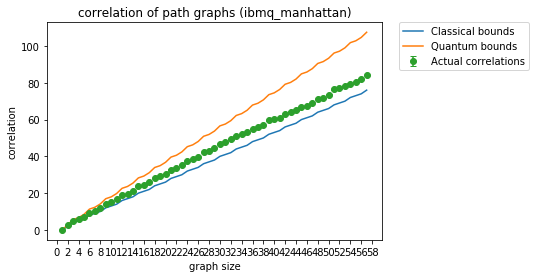

In [29]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds, label="Classical bounds") # , marker="o", markersize=1)
plt.plot(list(range(1, max_size + 1)), q_bounds, label="Quantum bounds") # , marker="x", markersize=1)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real, label="Actual correlations", fmt="o", yerr=stddev_list_real, capsize=3)
# plt.errorbar(list(range(1, 11 + 1)), tensored_corr_list_real, label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real, capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2))[::2])
plt.title("correlation of path graphs (ibmq_brooklyn)")
plt.show()